# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-06-07 07:54:24.590388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 07:54:24.590489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 07:54:24.710051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preparation

# Dataframe

In [2]:
import os
import pandas as pd

PATH = '/kaggle/input/indian-emotion/Audio Mode Only/'
file_emotion = []
file_path = []

emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

for emotion in emotions:
    emotion_folder = os.path.join(PATH, emotion)
    print(f"Checking folder: {emotion_folder}") 
    
    if os.path.isdir(emotion_folder):
        for file in os.listdir(emotion_folder):
            file_full_path = os.path.join(emotion_folder, file)
            #print(f"Found file: {file_full_path}") 
            file_path.append(file_full_path)
            file_emotion.append(emotion.lower())
    else:
        print(f"Folder not found: {emotion_folder}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.to_csv("crema_df.csv", index=False)
crema_df.head()


Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Anger
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Disgust
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Fear
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Happy
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Neutral
Checking folder: /kaggle/input/indian-emotion/Audio Mode Only/Sad


Emotions                                               Path
0    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
1    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
2    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
3    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...
4    anger  /kaggle/input/indian-emotion/Audio Mode Only/A...

# Data Visualisation and Exploration

In [3]:
crema_df.to_csv('/kaggle/working/pumave.csv', index=False)


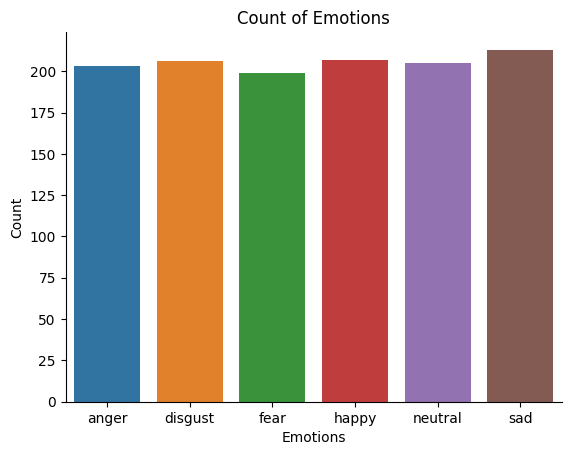

In [4]:
plt.title('Count of Emotions')
sns.countplot(x = crema_df.Emotions)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [5]:
def waveplot(data, sr, e):
  plt.figure(figsize = (10, 3))
  plt.title(f"{e} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (12, 3))
  plt.title(f"{e} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

In [6]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def waveplot(data, sr, emotion, ax):
    librosa.display.waveshow(data, sr=sr, ax=ax)
    ax.set_title(f'Waveform ({emotion})')

def spectrogram(data, sr, emotion, ax):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(f'Spectrogram ({emotion})')
    return img


In [10]:
crema_df['Emotions'].unique()

array(['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

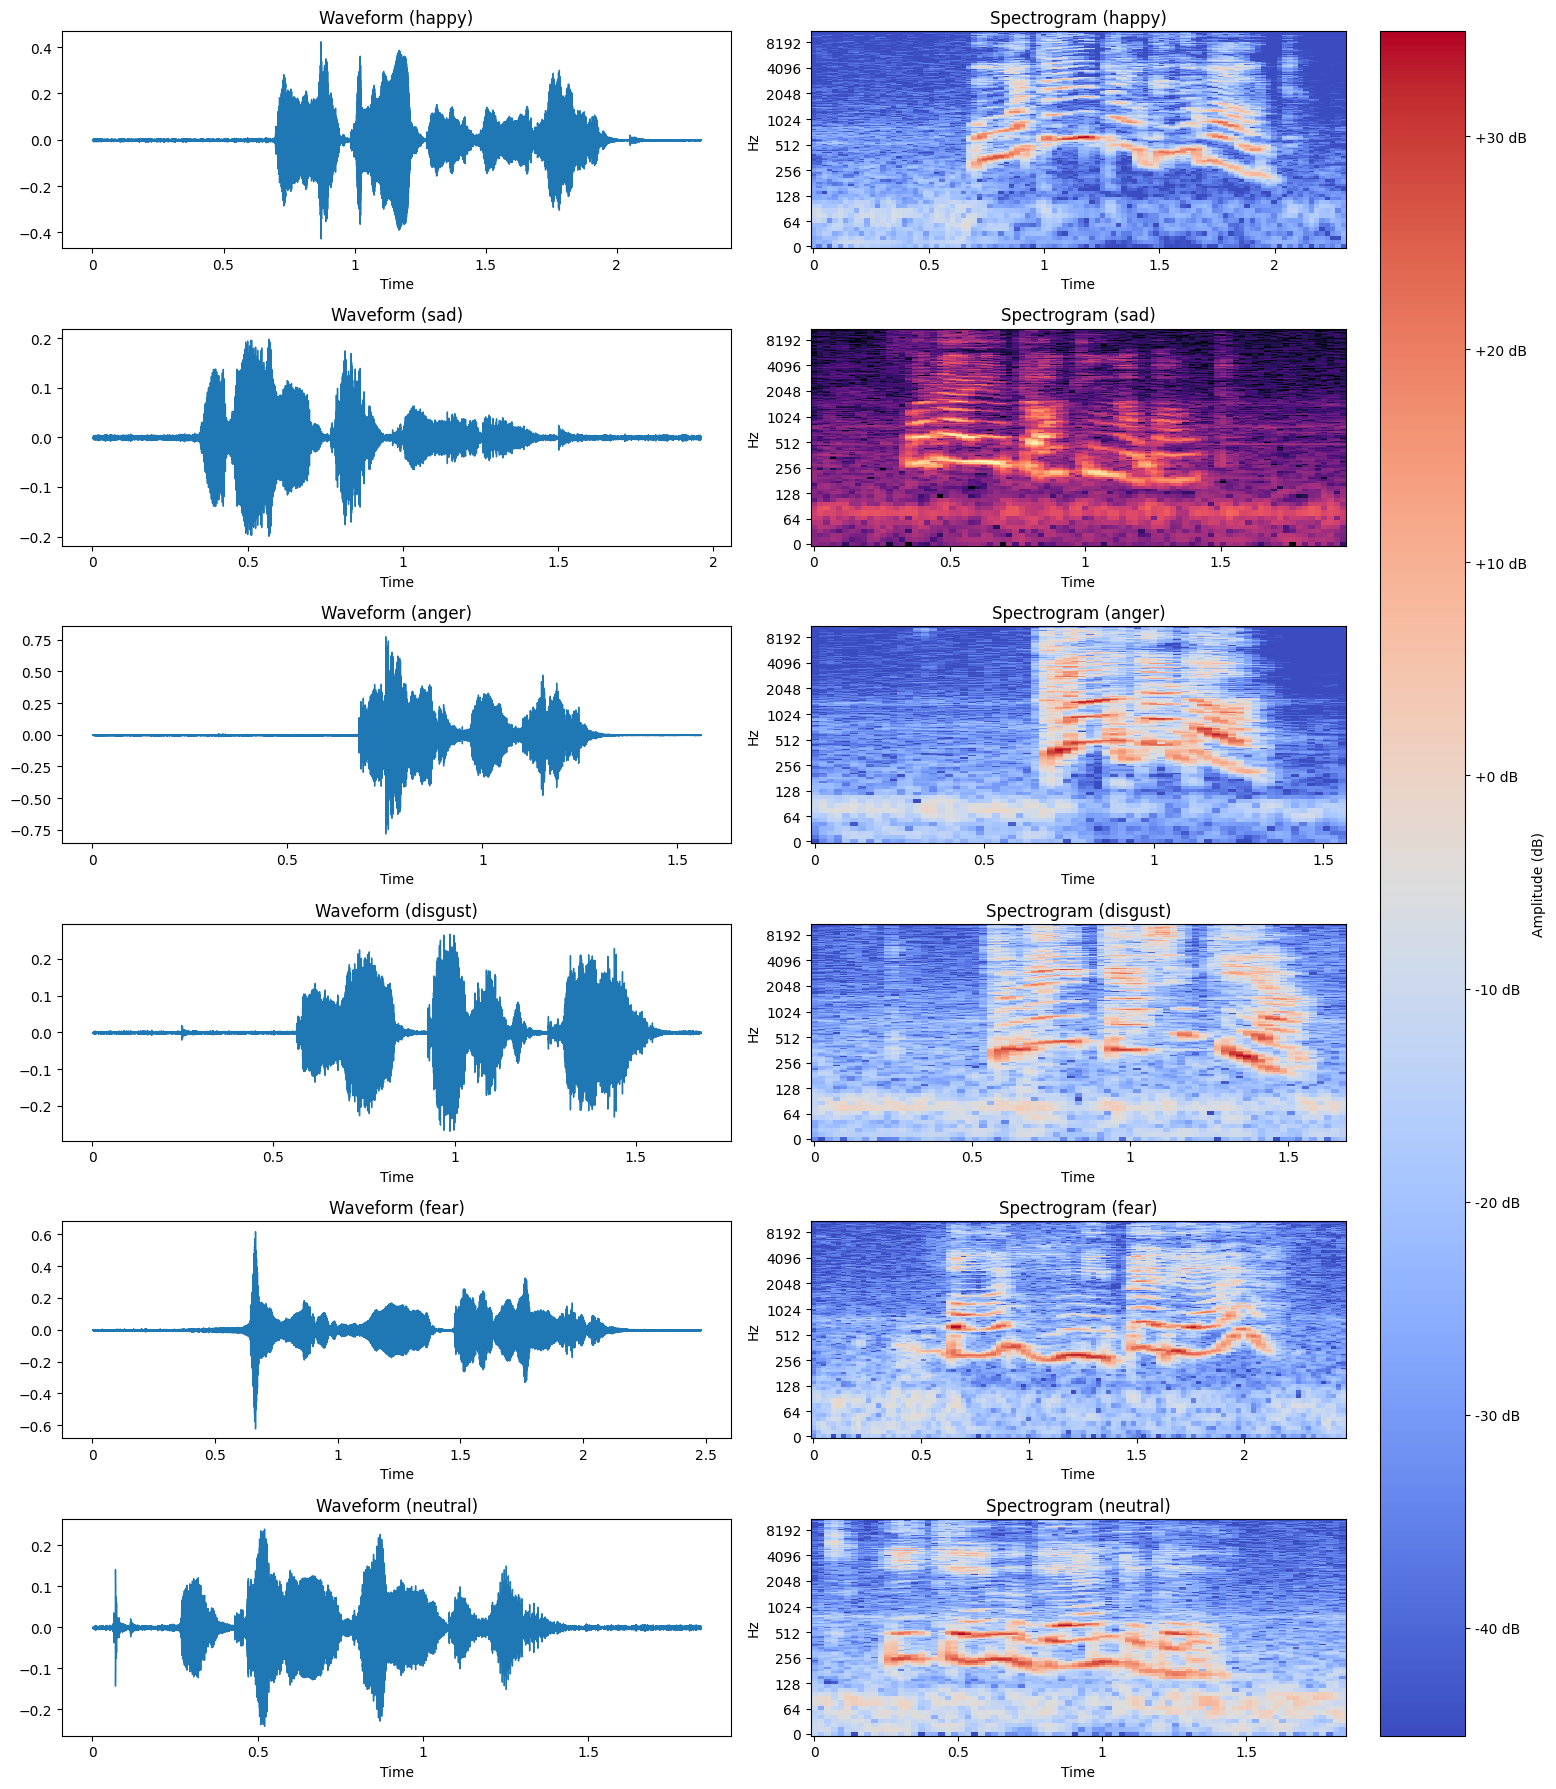

In [11]:
emotions = ['happy', 'sad', 'anger', 'disgust', 'fear', 'neutral']
fig, axs = plt.subplots(len(emotions), 2, figsize=(15, 3 * len(emotions)))

for i, emotion in enumerate(emotions):
    emotion_paths = crema_df.Path[crema_df.Emotions == emotion]
    if not emotion_paths.empty:
        path = np.array(emotion_paths)[0]  # Take the first path
        data, sr = librosa.load(path)
        waveplot(data, sr, emotion, axs[i, 0])
        img = spectrogram(data, sr, emotion, axs[i, 1])
    else:
        print(f"No paths found for emotion '{emotion}'")

plt.tight_layout()
cbar = fig.colorbar(img, ax=axs[:, 1], format="%+2.0f dB")
cbar.ax.set_ylabel('Amplitude (dB)')
plt.show()

# Data Augmentation

In [12]:
def noise(data):
  noise_amp = 0.035 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
  shift_range = int(np.random.uniform(low = -5, high = 5) * 1000)
  return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

path = np.array(crema_df.Path)[1]
data, sample_rate = librosa.load(path)

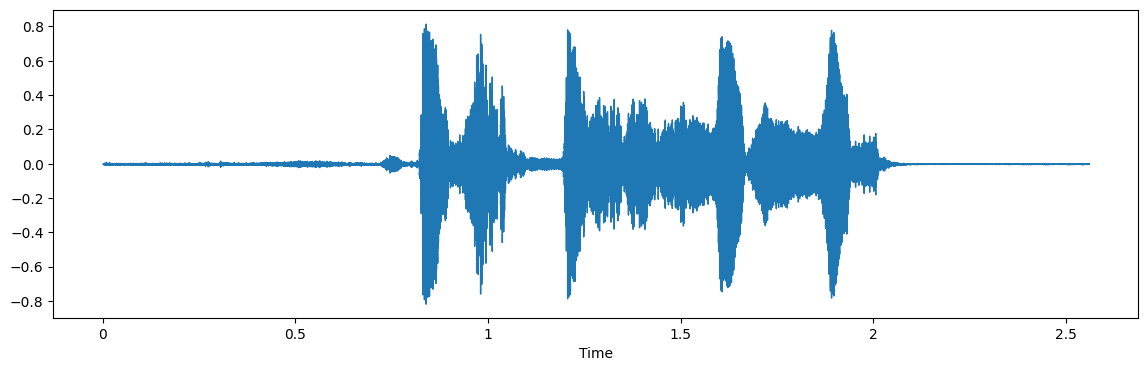

In [13]:
# Simple audio
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = data, sr = sample_rate)
Audio(path)

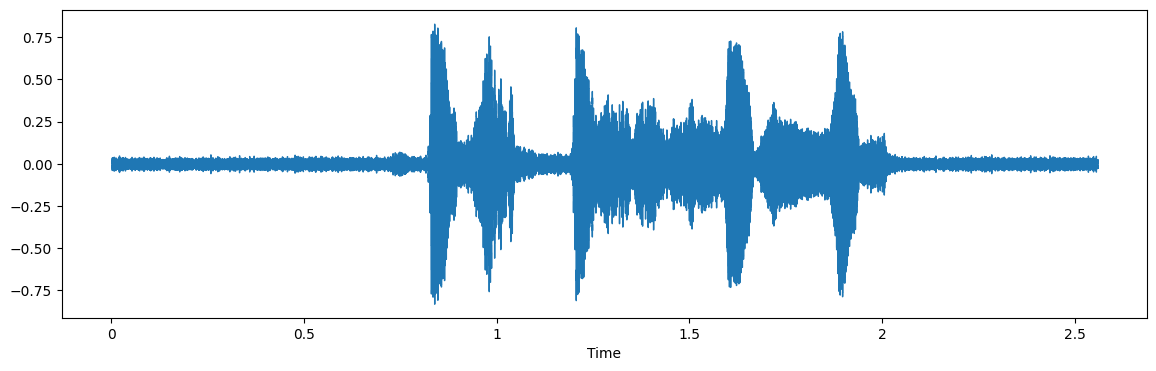

In [14]:
# Noise
x = noise(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

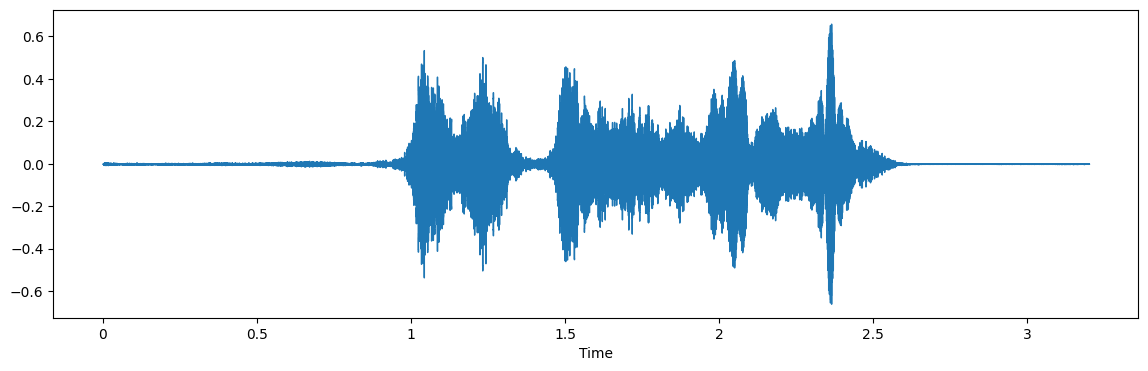

In [15]:
# Stretch
x = stretch(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

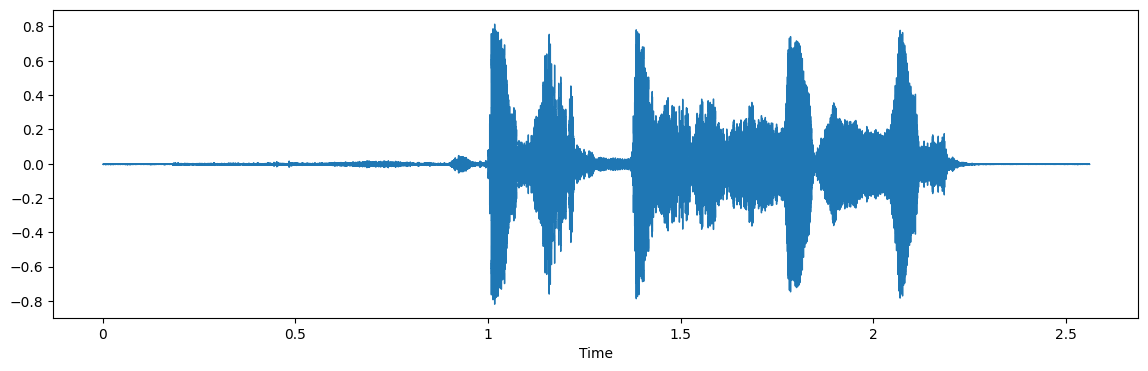

In [16]:
# Shift
x = shift(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

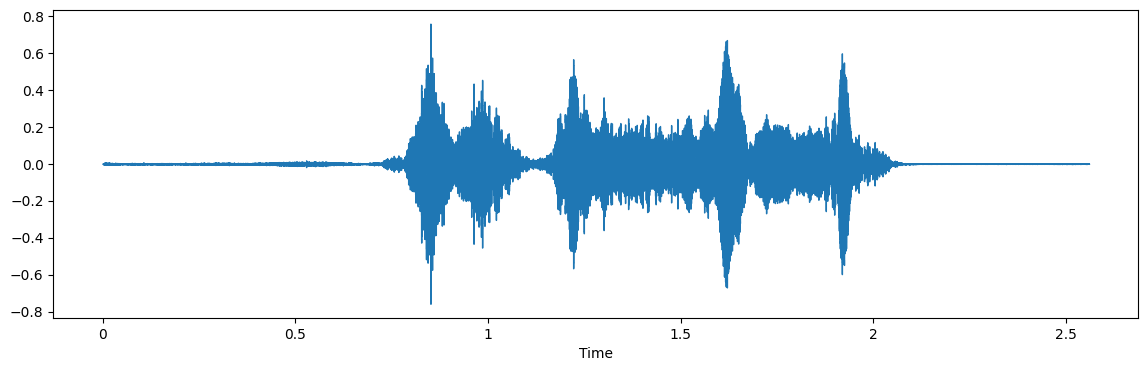

In [17]:
# Pitch
x = pitch(data, sampling_rate = sample_rate)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

# Feature Extraction

In [18]:
def extract_features(data):
    result = np.array([])

    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 20).T, axis = 0)
    result = np.hstack((result, mfcc))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    lowspeed_data = stretch(data, rate = 0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3))

    highspeed_data = stretch(data, rate = 1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4))

    pitch_data = pitch(data, sample_rate, n_steps = 0.8)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    shift_data = shift(data)
    res6 = extract_features(shift_data)
    result = np.vstack((result, res6))

    return result

In [19]:
X, Y = [], []
for path, emotion in zip(crema_df.Path, crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [20]:
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(path, emotion, X, Y):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return (path, emotion)

if __name__ == "__main__":
    X, Y = [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, emotion in zip(crema_df.Path, crema_df.Emotions):
            future = executor.submit(process_audio_file, path, emotion, X, Y)
            futures.append(future)

        for future in futures:
            path, emotion = future.result()
#             print(path, " : ", emotion)

In [21]:
len(X), len(Y), crema_df.Path.shape

(7398, 7398, (1233,))

In [22]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index = False)
features.head()

0          1          2          3          4          5  \
0 -283.483643  49.095856 -13.727013 -15.195500 -26.665066 -10.151899   
1 -132.513590  18.592100  -8.925721  -8.268968 -13.447767  -4.875124   
2 -306.927460  48.651505 -14.751535 -15.993977 -29.097511 -11.889460   
3 -299.179047  54.642479 -14.377996 -15.922089 -30.398088 -11.806766   
4 -297.915466  48.633194 -19.137106 -19.081839 -32.185627  -9.729286   

          6          7          8         9  ...        11         12  \
0 -1.156064 -32.112080 -12.262993  4.200815  ...  0.612122 -10.781008   
1 -1.787037 -15.328381  -7.737613  0.016937  ... -1.530129  -5.647656   
2 -1.818478 -33.667549 -14.577806  3.340514  ... -1.272149 -12.470752   
3 -0.618686 -33.265297 -16.426010  3.276934  ... -2.043457 -13.660760   
4 -6.444252 -34.383358  -7.710135  3.327308  ... -2.431576  -7.350149   

          13        14         15        16        17        18        19  \
0   7.474688  5.621745  13.082247  8.510781 -0.826373 -7.318433  2.758495   
1   2.138081  6.306089   7.601677  5.182577  0.188731 -5.972003  0.233145   
2   6.928035  5.149251  12.720300  8.439692 -0.893182 -8.671614  2.607773   
3   5.069514  4.467447  11.483495  8.575624 -0.378975 -8.105019  2.939501   
4  12.464415  5.679486  13.745461  1.787378 -5.090426 -4.952491  9.190484   

   labels  
0   anger  
1   anger  
2   anger  
3   anger  
4   anger  

[5 rows x 21 columns]

# Data Preparation

In [23]:
X = features.iloc[: ,: -1].values
Y = features['labels'].values

In [24]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5548, 20), (5548, 6), (1850, 20), (1850, 6))

In [26]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5548, 20), (5548, 6), (1850, 20), (1850, 6))

In [27]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5548, 20, 1), (5548, 6), (1850, 20, 1), (1850, 6))

# Modelling

In [28]:
model = Sequential([
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu',input_shape = (x_train.shape[1], 1)),
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    
    Flatten(),
    Dense(units = 6, activation = 'softmax'),
    
])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,118 (945.77 KB)

 Trainable params: 242,118 (945.77 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
mdcp = ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True)
#early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp, mdcp])

Epoch 1/200
44/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2594 - loss: 1.7058

I0000 00:00:1717748054.963301     190 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.2951 - loss: 1.6412 - val_accuracy: 0.4605 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4385 - loss: 1.3535 - val_accuracy: 0.4914 - val_loss: 1.2396 - learning_rate: 0.0010
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5067 - loss: 1.2196 - val_accuracy: 0.5562 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5620 - loss: 1.0754 - val_accuracy: 0.6000 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6165 - loss: 0.9635 - val_accuracy: 0.6508 - val_loss: 0.8849 - learning_rate: 0.0010
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6665 - loss: 0.8549 - val_accuracy: 0.6854 - val_loss: 0.8001 - learning_rate: 0.0010
Epoch 7/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7076 - loss: 0.7671 - val_accuracy: 0.7

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9269 - loss: 0.3260
Testing Accuracy:  91.5135145187378 %


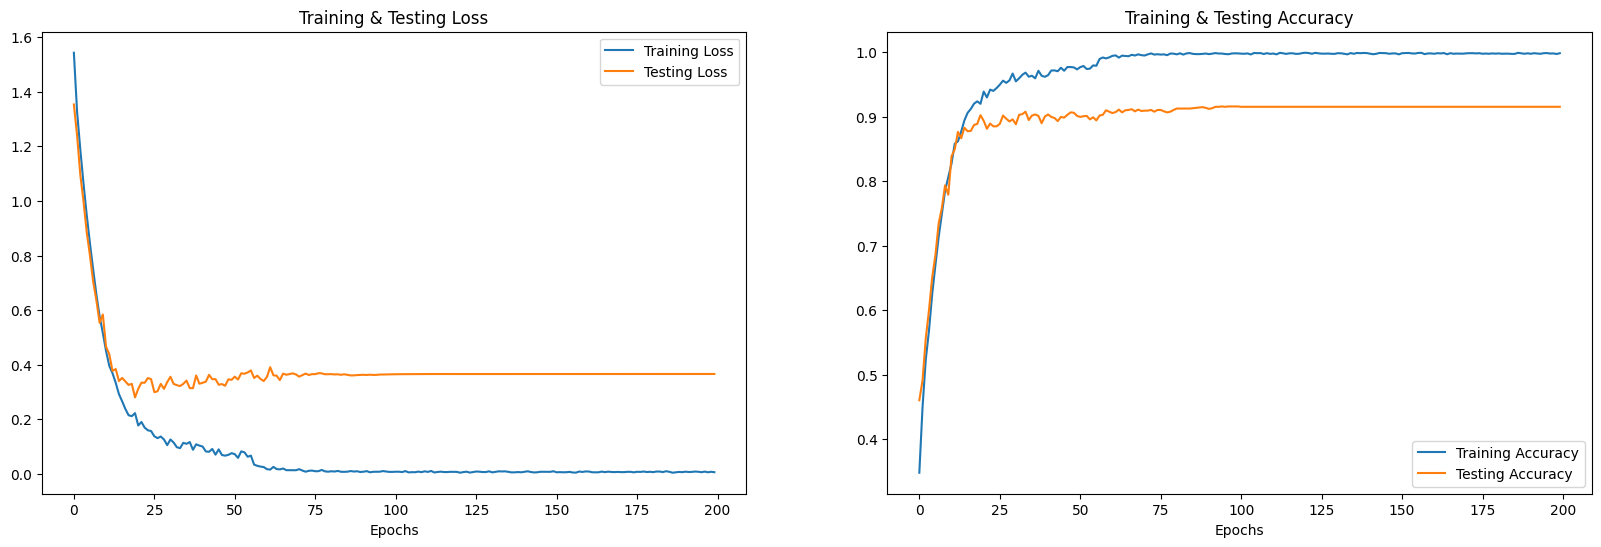

In [31]:
print("Testing Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [33]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust          fear
1              sad           sad
2             fear          fear
3            anger         anger
4          disgust       disgust
5              sad           sad
6            happy         happy
7          neutral       neutral
8             fear          fear
9          disgust       disgust

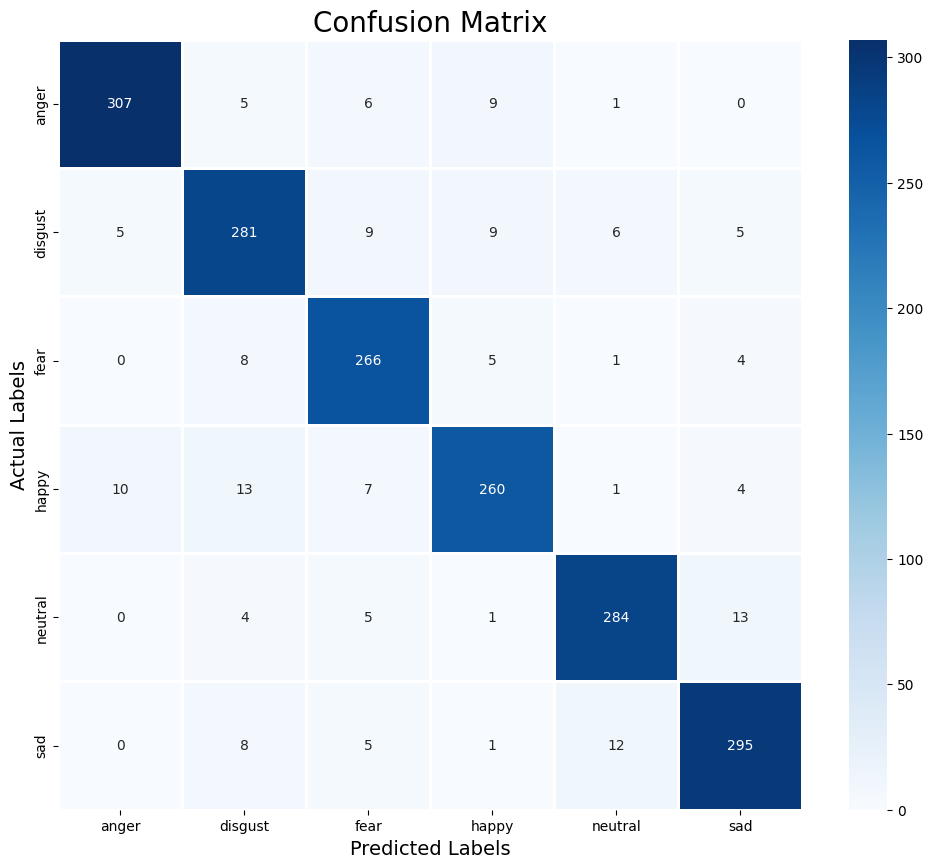

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [35]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print(classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

       anger       0.95      0.94      0.94       328
     disgust       0.88      0.89      0.89       315
        fear       0.89      0.94      0.91       284
       happy       0.91      0.88      0.90       295
     neutral       0.93      0.93      0.93       307
         sad       0.92      0.92      0.92       321

    accuracy                           0.92      1850
   macro avg       0.91      0.92      0.91      1850
weighted avg       0.92      0.92      0.92      1850

